In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, plot_confusion_matrix, classification_report
%matplotlib inline

In [149]:
# read in csv
df = pd.read_csv('Data Collection/combined_df.csv')

In [150]:
# separate data and target columns
target_cols = ['2012_voted_num', '2016_voted_num', '2020_voted_num', 
               '2012_voted_perc', '2016_voted_perc', '2020_voted_perc',
               '2012_early_vote_num', '2016_early_vote_num', '2020_early_vote_num',
               '2012_early_vote_perc', '2016_early_vote_perc', '2020_early_vote_perc',
               '2020_rep_vote_count', '2020_rep_vote_perc', '2020_dem_vote_count',
               '2020_dem_vote_perc', '2020_lib_vote_count', '2020_lib_vote_perc',
               '2020_grn_vote_count', '2020_grn_vote_perc', '2020_oth_vote_count',
               '2020_oth_vote_perc', '2020_votes_total', '2016_rep_vote_counte',
               '2016_rep_vote_perc', '2016_dem_vote_count', '2016_dem_vote_perc',
               '2016_lib_vote_count', '2016_lib_vote_perc', '2016_grn_vote_count',
               '2016_grn_vote_perc', '2016_oth_vote_count', '2016_oth_vote_perc',
               '2016_votes_total', '2012_rep_vote_perc', '2012_rep_vote_count',
               '2012_dem_vote_perc', '2012_dem_vote_count', '2012_oth_vote_perc',
               '2012_oth_vote_count', '2012_vote_total']

X = df.drop(columns = target_cols)

# isolate data by year
cols_2012 = [col for col in X.columns if '2012' in col]
cols_2012.insert(0,'county')
cols_2016 = [col for col in X.columns if '2016' in col]
cols_2016.insert(0,'county')
cols_2020 = [col for col in X.columns if '2020' in col]
cols_2020.insert(0,'county')


----
# Predicting Voter Turnout by County

This section creates a LASSO Regression Model predicting total voter turnout by county. The model is trained on data from 2012, and then applied to 2016 and 2020 data. 

We chose not to scale the data as the model performed better with non-scaled data. Additionally, it makes the coefficients slightly easier to interpret, although comparing coefficients necessitates caution since variables are on different scales. 

We chose this model because it is easy to interpret, and outperformed other regressors (KNeighbors, Random Forest) on RMSE and R2 metrics.

In [151]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
y = df['2012_voted_num']

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# fit Elastic Net model
el = ElasticNet(l1_ratio = 1, max_iter = 100000)
el.fit(X_train_2012, y_train_2012)
print(el.score(X_train_2012, y_train_2012))
print(el.score(X_test_2012, y_test_2012))

0.998380306225645
0.9926398589046923


- Our model is slightly overfit, but not terribly. We'll keep the features used. 

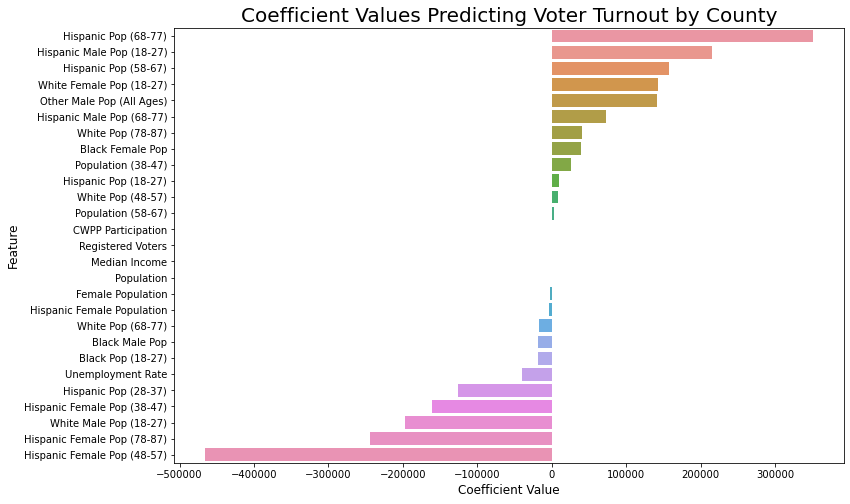

In [152]:
# plot coefficients
plt.figure(figsize = (12, 8))

# get data
betas = pd.DataFrame(el.coef_, columns=['betas'])
betas['Feature'] = X_2012.columns
data = betas[betas['betas'] != 0].sort_values(by='betas', ascending=False)

# plot and rename features
sns.barplot(data = data, y = 'Feature', x = 'betas', orient = 'h');
plt.yticks(ticks = range(27), labels = [
    'Hispanic Pop (68-77)', 
    'Hispanic Male Pop (18-27)',
    'Hispanic Pop (58-67)',
    'White Female Pop (18-27)',
    'Other Male Pop (All Ages)',
    'Hispanic Male Pop (68-77)',
    'White Pop (78-87)',
    'Black Female Pop',
    'Population (38-47)',
    'Hispanic Pop (18-27)',
    'White Pop (48-57)',
    'Population (58-67)',
    'CWPP Participation',
    'Registered Voters',
    'Median Income',
    'Population',
    'Female Population',
    'Hispanic Female Population',
    'White Pop (68-77)',
    'Black Male Pop',
    'Black Pop (18-27)',
    'Unemployment Rate',
    'Hispanic Pop (28-37)',
    'Hispanic Female Pop (38-47)',
    'White Male Pop (18-27)',
    'Hispanic Female Pop (78-87)',
    'Hispanic Female Pop (48-57)'
])
plt.title('Coefficient Values Predicting Voter Turnout by County', fontsize = 20)
plt.ylabel('Feature', fontsize = 12)
plt.xlabel('Coefficient Value', fontsize = 12);

Interesting Observations:
- The population proportion of Black women has a positive effect on voter turnout versus that of Black men has a negative effect on voter turnout
- The population of Black Women between 2012 and 2014 increased twice as much as White Women

>Black women have the strongest turnout among women of color. In both 2008 and 2012, black women turned out in such large numbers that they were actually overrepresented in the electorate, meaning that they were a higher proportion of the electorate than of their share of the voting-eligible population. 

![WOC Vote Table](WOCvoters.png)

Source: https://www.americanprogress.org/issues/race/reports/2014/10/30/99962/women-of-color/

- Generally, voting rates increase with age, which could explain why White Men (18-27) show a strong negative impact on voter turnout

- One explanation for Hispanic Female Population (38-47) having a strong negative impact on voter turnout could be the barriers to voting in counties with high Hispanic populations, which disproportionately effect those who work during Poling Station hours and have poor access to transportation. 


In [153]:
def display_metrics(df, X, cols, target, est):
    X_year = X[cols]
    X_year.set_index('county', inplace = True)
    y = df[target]
    score = est.score(X_year, y)
    preds = est.predict(X_year)
    mse = mean_squared_error(y_true = y, y_pred = preds, squared = False)
    baseline_mse = mean_squared_error(y_true = y, y_pred = [y.mean()] * len(y), squared = False)
    reduced_error = 100 - (100*mse/baseline_mse)
    print('RMSE:          ', round(mse))
    print('Baseline RMSE: ', round(baseline_mse))
    print('Reduced Error: ', str(round(reduced_error, 2)) + '%')
    print('R2:            ', round(score,4))
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x = preds, y = preds-y)
    plt.xlabel('Predicted Voter Turnout', fontsize = 12)
    plt.ylabel('Residual', fontsize = 12)
    plt.title('Residual Plot of Predicted Values', fontsize = 15)
    plt.hlines(y = 0, color = 'r', xmin = -10, xmax = max(preds)+1000000)
    plt.xlim((0, max(preds)+100000));

RMSE:           4538
Baseline RMSE:  106338
Reduced Error:  95.73%
R2:             0.9982


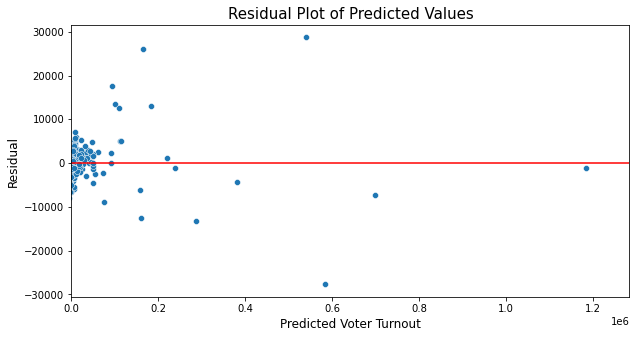

In [154]:
display_metrics(df, X, cols_2012, '2012_voted_num', el)

RMSE:           6456
Baseline RMSE:  118386
Reduced Error:  94.55%
R2:             0.997


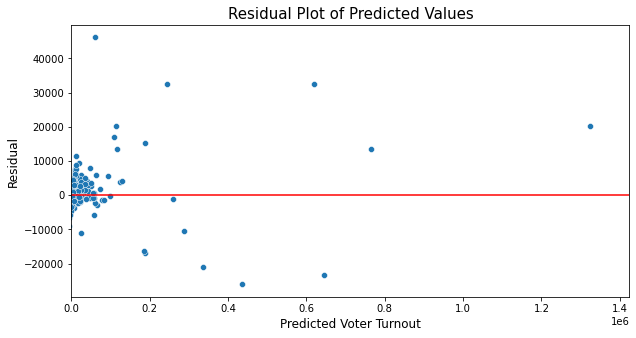

In [155]:
display_metrics(df, X, cols_2016, '2016_voted_num', el)

RMSE:           17773
Baseline RMSE:  147720
Reduced Error:  87.97%
R2:             0.9855


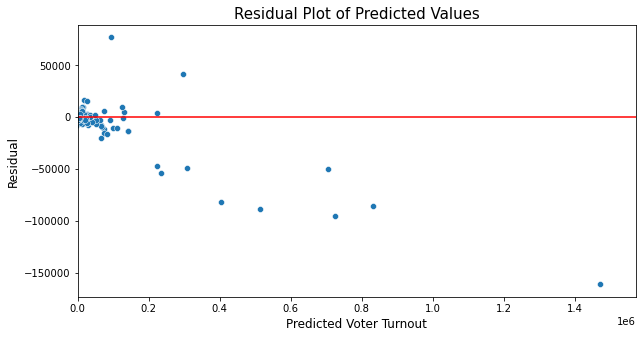

In [156]:
display_metrics(df, X, cols_2020, '2020_voted_num', el)

We were able to reduce error from baseline models a minimum of 86% with our model. We chose to train our model on 2012 data since 2016 was worse at predicting 2020 voter turnout. 2020 was also a historic election in terms of voter turnout, so it is commendable that the model could achieve such good metrics. Next steps here would be to combine 2012 and 2016 data, train a LASSO regression model on that, and then use that model to predict 2020 voter turnout. 

However, when looking at the residual plots, our model performed much better at predicting small county voter turnout.
Considering some politicians are starting to focus on community-level organizing, this model could be useful in predicting turnout on a smaller scale. An example of this is Stacey Abrams' campaign approach. For more information, check out this [podcast](https://www.nytimes.com/2021/01/04/podcasts/the-daily/georgia-runoffs-stacey-abrams.html).

----
# Predicting Republican Voter Turnout by County
In this section we will get more specific with our target and train a model on 2012 data to predict voting totals for the Republican Presidential candidates.

In [159]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
X_2016 = X[cols_2016]
X_2016.set_index('county', inplace = True)
X_2020 = X[cols_2020]
X_2020.set_index('county', inplace = True)
y = df['2012_rep_vote_count']

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# Conduct Gridsearch on ElasticNet

pipe_params = {
    'alpha': [327.75],
    'l1_ratio': [1]
}
gs_r = GridSearchCV(ElasticNet(max_iter = 100_000), pipe_params, cv = 3, verbose=1)
gs_r.fit(X_train_2012, y_train_2012)
print(gs_r.score(X_train_2012, y_train_2012))
print(gs_r.score(X_test_2012, y_test_2012))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0.9661729636883134
0.918458871251818


RMSE:           10182
Baseline RMSE:  53111
Reduced Error:  80.83%
R2:             0.9632


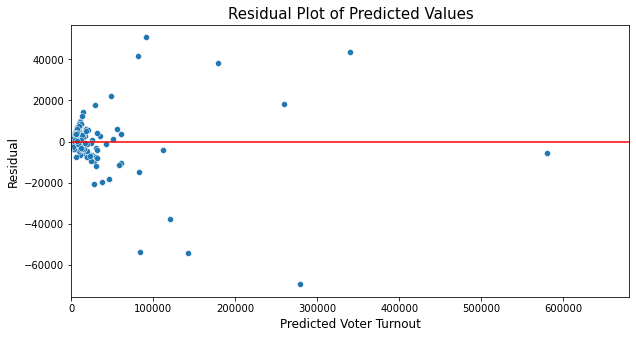

In [160]:
display_metrics(df, X, cols_2012, '2012_rep_vote_count', gs_r)

RMSE:           11730
Baseline RMSE:  51047
Reduced Error:  77.02%
R2:             0.9472


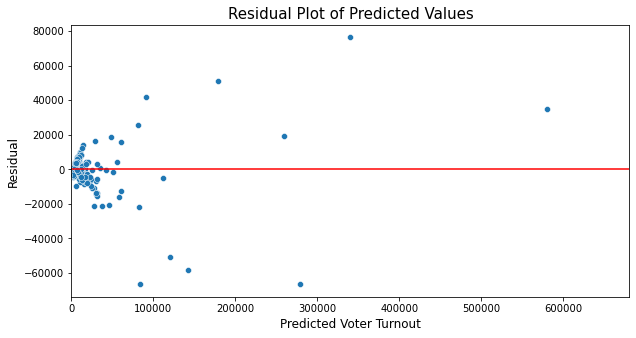

In [161]:
display_metrics(df, X, cols_2012, '2016_rep_vote_counte', gs_r)


RMSE:           18894
Baseline RMSE:  64284
Reduced Error:  70.61%
R2:             0.9136


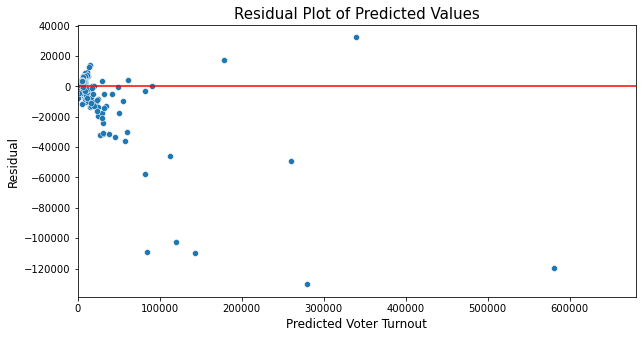

In [162]:
display_metrics(df, X, cols_2012, '2020_rep_vote_count', gs_r)

- Our model mostly underpredicted voter turnout by county in 2020. True vote numbers were very high this year, and the circumstances of voting during a pandemic accounts for a significant portion of the remaining residuals.

----
# Predicting Democrat Voter Turnout by County
In this section we will get more specific with our target and train a model on 2012 data to predict voting totals for the Democrat Presidential candidates.

In [163]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
X_2016 = X[cols_2016]
X_2016.set_index('county', inplace = True)
X_2020 = X[cols_2020]
X_2020.set_index('county', inplace = True)
y = df['2012_dem_vote_count']

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# Conduct Gridsearch on ElasticNet

pipe_params = {
    'alpha': [990],
    'l1_ratio': [1]
}
gs_d = GridSearchCV(ElasticNet(max_iter = 100_000), pipe_params, cv = 5, verbose=1)
gs_d.fit(X_train_2012, y_train_2012)
print(gs_d.score(X_train_2012, y_train_2012))
print(gs_d.score(X_test_2012, y_test_2012))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9799001647358815
0.9324870708706102


RMSE:           7859
Baseline RMSE:  53499
Reduced Error:  85.31%
R2:             0.9784


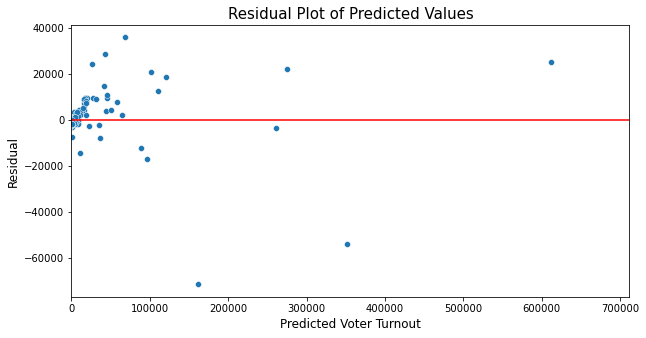

In [164]:
display_metrics(df, X, cols_2012, '2012_dem_vote_count', gs_d)

RMSE:           13784
Baseline RMSE:  64366
Reduced Error:  78.58%
R2:             0.9541


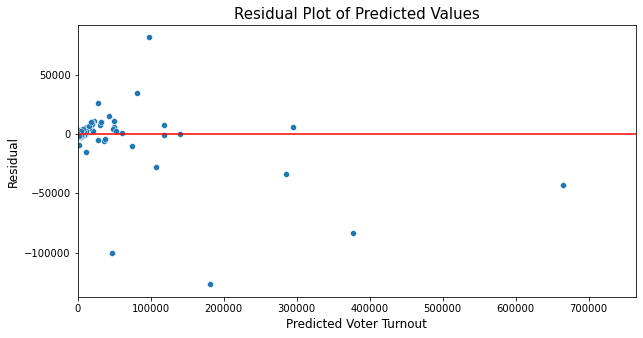

In [165]:
display_metrics(df, X, cols_2016, '2016_dem_vote_count', gs_d)

RMSE:           28400
Baseline RMSE:  86318
Reduced Error:  67.1%
R2:             0.8917


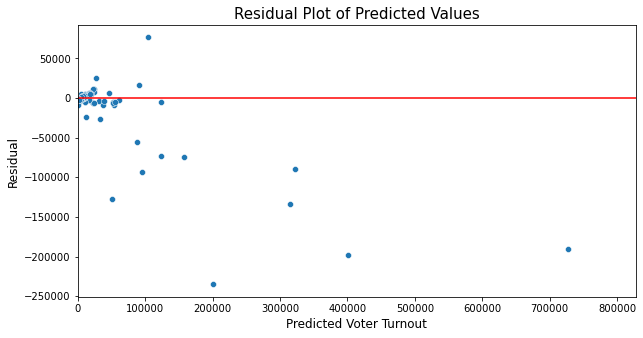

In [166]:
display_metrics(df, X, cols_2020, '2020_dem_vote_count', gs_d)

- We see slightly less clustering in residuals of the Democrat predictions. This could possibly be because Democrat voters are composed of a more diverse voter base, so it is more difficult to predict outcomes with population data. 

----
# Could we predict who won in 2016?

-- Chloe -- add in predictions from voter turnout here too!
-- Chloe -- also try a logistic regression to plot redness/bluenesss by county

In [167]:
dem_2016_pred = round(gs_d.predict(X_2016).sum())

In [168]:
dem_2016_true = df['2016_dem_vote_count'].sum()

In [169]:
rep_2016_pred = round(gs_r.predict(X_2016).sum())

In [170]:
rep_2016_true = df['2016_rep_vote_counte'].sum()

In [171]:
value = ['Predicted', 'True', 'Predicted', 'True']
votes = [rep_2016_pred, rep_2016_true, dem_2016_pred, dem_2016_true]
party = ['Republican', 'Republican', 'Democrat', 'Democrat']
elect_2016 = pd.DataFrame(votes, columns=['Votes'])
elect_2016['Party'] = party
elect_2016['Value'] = value

In [172]:
elect_2016

,Votes,Party,Value
0,4844530,Republican,Predicted
1,4685047,Republican,True
2,3630790,Democrat,Predicted
3,3877868,Democrat,True


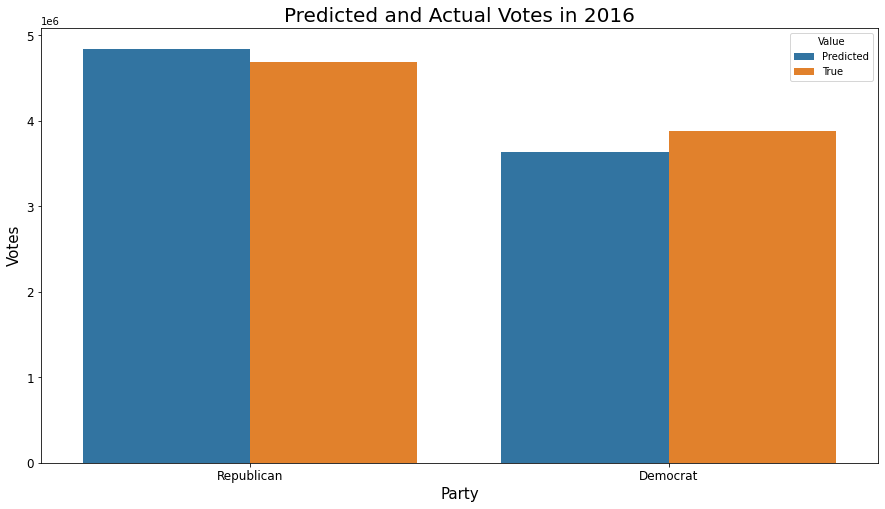

In [173]:
plt.figure(figsize = (15, 8))
sns.barplot(data=elect_2016, x = 'Party', y = 'Votes', hue = 'Value')
plt.xticks(fontsize = 12)
plt.xlabel('Party', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Votes', fontsize = 15)
plt.title('Predicted and Actual Votes in 2016', fontsize = 20);

# Could we predict who won in 2020?

In [174]:
dem_2020_pred = round(gs_d.predict(X_2020).sum())

In [175]:
dem_2020_true = df['2020_dem_vote_count'].sum()

In [176]:
rep_2020_pred = round(gs_r.predict(X_2020).sum())

In [177]:
rep_2020_true = df['2020_rep_vote_count'].sum()

In [178]:
value = ['Predicted', 'True', 'Predicted', 'True']
votes = [rep_2020_pred, rep_2020_true, dem_2020_pred, dem_2020_true]
party = ['Republican', 'Republican', 'Democrat', 'Democrat']
elect_2020 = pd.DataFrame(votes, columns=['Votes'])
elect_2020['Party'] = party
elect_2020['Value'] = value

In [179]:
elect_2020

,Votes,Party,Value
0,5382272,Republican,Predicted
1,5890347,Republican,True
2,3866803,Democrat,Predicted
3,5259126,Democrat,True


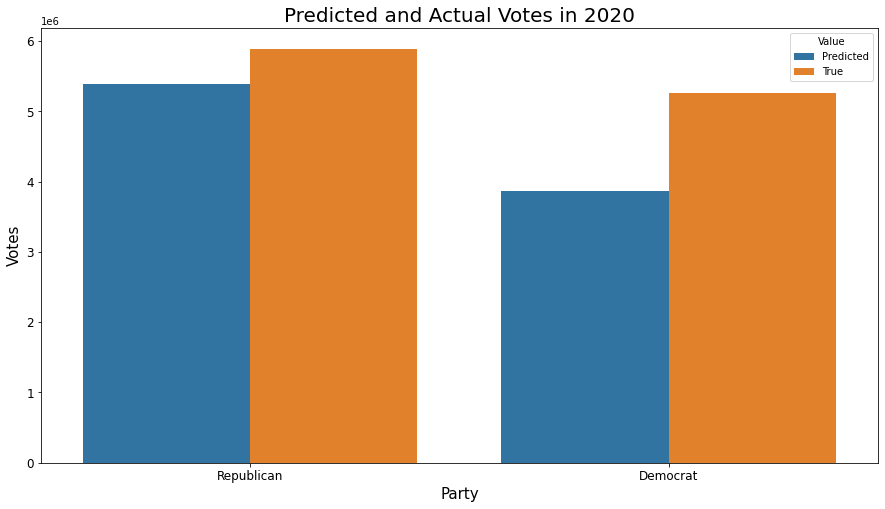

In [180]:
plt.figure(figsize = (15, 8))
sns.barplot(data=elect_2020, x = 'Party', y = 'Votes', hue = 'Value')
plt.xticks(fontsize = 12)
plt.xlabel('Party', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Votes', fontsize = 15)
plt.title('Predicted and Actual Votes in 2020', fontsize = 20);

---
# Logistic Regression to Predict Blue/Red Probabilities per County

In [199]:
# set X and y
X_2012 = X[cols_2012]
X_2012.set_index('county', inplace = True)
X_2016 = X[cols_2016]
X_2016.set_index('county', inplace = True)
X_2020 = X[cols_2020]
X_2020.set_index('county', inplace = True)
y = [1 if df['2012_dem_vote_count'][i] > df['2012_rep_vote_count'][i] else 0 for i in range(len(df['2012_dem_vote_count']))]

# train test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X_2012, y, random_state = 100)

# Conduct Gridsearch on Logistic Regression:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())
])

# narrowed down to these metrics based on training and testing accuracy in gridsearch
pipe_params = {
    'sc__with_mean'   : [False],
    'sc__with_std'    : [True],
    'logreg__penalty' : ['elasticnet'],
    'logreg__C'       : [.1],
    'logreg__solver'  : ['saga'],
    'logreg__l1_ratio': [.22222],
    'logreg__max_iter': [100_000]

}

gs_logreg = GridSearchCV(pipe, pipe_params, cv = 5, verbose=1)
gs_logreg.fit(X_train_2012, y_train_2012)
print(gs_logreg.score(X_train_2012, y_train_2012))
print(gs_logreg.score(X_test_2012, y_test_2012))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.968421052631579
0.96875


In [191]:
y_12 = [1 if df['2012_dem_vote_count'][i] > df['2012_rep_vote_count'][i] else 0 for i in range(len(df['2012_dem_vote_count']))]
y_16 = [1 if df['2016_dem_vote_count'][i] > df['2016_rep_vote_counte'][i] else 0 for i in range(len(df['2016_dem_vote_count']))]
y_20 = [1 if df['2020_dem_vote_count'][i] > df['2020_rep_vote_count'][i] else 0 for i in range(len(df['2020_dem_vote_count']))]


In [273]:
def class_metrics(X, rep, dem):
    y = [1 if df[dem][i] > df[rep][i] else 0 for i in range(len(df[dem]))]
    preds = gs_logreg.predict(X)
    plot_confusion_matrix(gs_logreg, X, y, cmap = 'viridis', normalize = 'true')
    plt.title(f'Confusion Matrix {rep[:4]}')
    print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       228
           1       1.00      0.69      0.82        26

    accuracy                           0.97       254
   macro avg       0.98      0.85      0.90       254
weighted avg       0.97      0.97      0.97       254



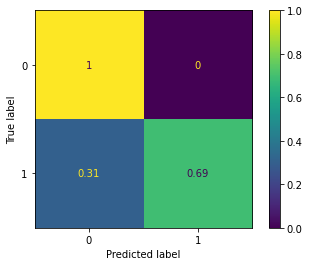

In [274]:
class_metrics(X_2012, '2012_rep_vote_count', '2012_dem_vote_count')


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       227
           1       0.86      0.70      0.78        27

    accuracy                           0.96       254
   macro avg       0.91      0.85      0.88       254
weighted avg       0.95      0.96      0.95       254



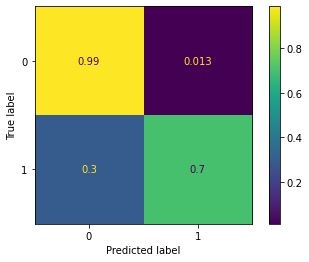

In [275]:
class_metrics(X_2016, '2016_rep_vote_counte', '2016_dem_vote_count')

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       232
           1       0.53      0.77      0.63        22

    accuracy                           0.92       254
   macro avg       0.75      0.85      0.79       254
weighted avg       0.94      0.92      0.93       254



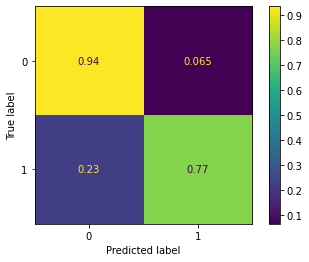

In [276]:
class_metrics(X_2020, '2020_rep_vote_count', '2020_dem_vote_count')

In [260]:
def get_probs(X):
    probs = gs_logreg.predict_proba(X)[:, 1]
    probs_df = pd.DataFrame(probs, columns = ['Probability County=Democrat'], index=X.index)
    return probs_df

In [263]:
probs_12 = get_probs(X_2012)
probs_16 = get_probs(X_2016)
probs_20 = get_probs(X_2020)

In [265]:
probs_12.to_csv('output/probs_12.csv')
probs_16.to_csv('output/probs_16.csv')
probs_20.to_csv('output/probs_20.csv')